In [1]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
zarr_paths = sorted(glob.glob("/Users/devseed/Documents/repos/eopf-cpm/02_zarr_converted/*.zarr"))
datatrees = [xr.open_datatree(path, consolidated=True) for path in zarr_paths]
datasets = [xr.open_dataset(path, consolidated=True) for path in zarr_paths]

DATASET_NUMBER = 19

# To check for ID number of datatrees
# datatrees[1].groups
MEASUREMENTS_VH_GROUP_ID = 4
MEASUREMENTS_VV_GROUP_ID = 7
GCP_VH_GROUP_ID = 14
GCP_VV_GROUP_ID = 28
CALIBRATION_VH_GROUP_ID = 19
CALIBRATION_VV_GROUP_ID = 33

WATER_THRESHOLD_DB = -15
OTHER_THRESHOLD_DB = -20

In [3]:
# Create measurements list VV
i = 0
measurementsVV = []
while i < DATASET_NUMBER:
    measurementsVV.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_VV_GROUP_ID]].to_dataset())
    i = i + 1

In [4]:
# Create measurements list VH
i = 0
measurementsVH = []
while i < DATASET_NUMBER:
    measurementsVH.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_VH_GROUP_ID]].to_dataset())
    i = i + 1

In [5]:
# Create decimated grd list VV for the whole product
grddecimatedVV = []
for i in range(DATASET_NUMBER):
    da = measurementsVV[i].grd
    az_len = da.sizes['azimuth_time']
    gr_len = da.sizes['ground_range']
    
    grddecimatedVV.append(da.isel(
        azimuth_time=slice(None, None, 10),
        ground_range=slice(None, None, 10)
    ))

In [6]:
# Create decimated grd list VH for the whole product
grddecimatedVH = []
for i in range(DATASET_NUMBER):
    da = measurementsVH[i].grd
    az_len = da.sizes['azimuth_time']
    gr_len = da.sizes['ground_range']
    
    grddecimatedVH.append(da.isel(
        azimuth_time=slice(None, None, 10),
        ground_range=slice(None, None, 10)
    ))

In [7]:
# Create decimated grd list VV
grdVV = []
for i in range(DATASET_NUMBER):
    da = measurementsVV[i].grd
    az_len = da.sizes['azimuth_time']
    gr_len = da.sizes['ground_range']
    
    grdVV.append(da.isel(
        azimuth_time=slice(max(0, az_len - 10000), az_len, 5),
        ground_range=slice(max(0, gr_len - 10000), gr_len, 5)
    ))

In [8]:
# Create decimated grd list VH
grdVH = []
for i in range(DATASET_NUMBER):
    da = measurementsVH[i].grd
    az_len = da.sizes['azimuth_time']
    gr_len = da.sizes['ground_range']
    
    grdVH.append(da.isel(
        azimuth_time=slice(max(0, az_len - 10000), az_len, 5),
        ground_range=slice(max(0, gr_len - 10000), gr_len, 5)
    ))

In [9]:
# set(dat.ground_range.shape for dat in measurementsVV) # to see if all measurements have the same shape - they don't have
# set(dat.ground_range.shape for dat in grdVV) # to see if all grd have the same shape - they have

In [10]:
# Create GCP (interpolated with decimated grd) list VV
i = 0
gcpVV = []
while i < DATASET_NUMBER:
    gcpVV.append(datatrees[i][datatrees[i].groups[GCP_VV_GROUP_ID]].to_dataset())
    gcpVV[i] = gcpVV[i].interp_like(grdVV[i])
    i = i + 1

In [11]:
# Create GCP (interpolated with decimated grd) list VH
i = 0
gcpVH = []
while i < DATASET_NUMBER:
    gcpVH.append(datatrees[i][datatrees[i].groups[GCP_VH_GROUP_ID]].to_dataset())
    gcpVH[i] = gcpVH[i].interp_like(grdVH[i])
    i = i + 1

In [12]:
# Assinging lat and long coordinates to grd VV
i = 0
while i < DATASET_NUMBER:
    grdVV[i] = grdVV[i].assign_coords({"latitude": gcpVV[i].latitude, 
                                   "longitude": gcpVV[i].longitude})
    i = i + 1

In [13]:
# Assinging lat and long coordinates to grd VH
i = 0
while i < DATASET_NUMBER:
    grdVH[i] = grdVH[i].assign_coords({"latitude": gcpVH[i].latitude, 
                                   "longitude": gcpVH[i].longitude})
    i = i + 1

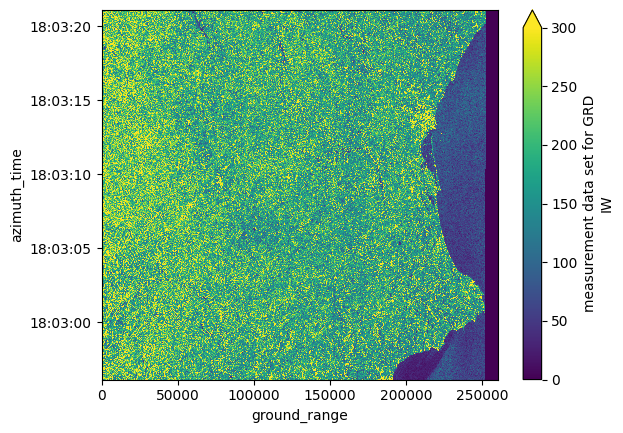

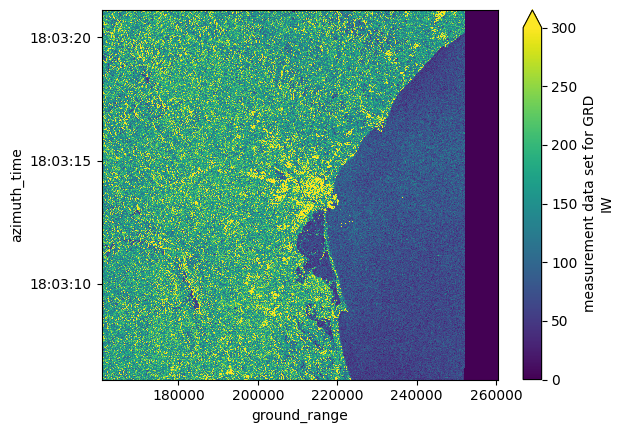

In [14]:
for i in [grddecimatedVV[2], grdVV[2]]:
    i.plot(vmax=300)
    # i.plot(x="longitude", y="latitude", vmax=300)
    plt.show()

In [15]:
# Create calibration list VV
i = 0
calibrationVV = []
while i < DATASET_NUMBER:
    calibrationVV.append(datatrees[i][datatrees[i].groups[CALIBRATION_VV_GROUP_ID]].to_dataset())
    gcpVV[i] = gcpVV[i].interp_like(grdVV[i])
    i = i + 1

In [16]:
# Create calibration list VH
i = 0
calibrationVH = []
while i < DATASET_NUMBER:
    calibrationVH.append(datatrees[i][datatrees[i].groups[CALIBRATION_VH_GROUP_ID]].to_dataset())
    gcpVH[i] = gcpVH[i].interp_like(grdVH[i])
    i = i + 1

In [17]:
# Calibrate intensity for each product VV
i = 0
intensityVV = []
while i < DATASET_NUMBER:
    intensityVV.append(xarray_sentinel.calibrate_intensity(
        grdVV[i], 
        calibrationVV[i].beta_nought, 
        as_db=True))
    i = i + 1


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [18]:
# Calibrate intensity for each product VH
i = 0
intensityVH = []
while i < DATASET_NUMBER:
    intensityVH.append(xarray_sentinel.calibrate_intensity(
        grdVH[i], 
        calibrationVH[i].beta_nought, 
        as_db=True))
    i = i + 1


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [19]:
# Calibrate amplitude for each product VV
i = 0
amplitudeVV = []
while i < DATASET_NUMBER:
    amplitudeVV.append(xarray_sentinel.calibrate_amplitude(
        grdVV[i], 
        calibrationVV[i].beta_nought))
    i = i + 1

In [20]:
# Calibrate amplitude for each product VH
i = 0
amplitudeVH = []
while i < DATASET_NUMBER:
    amplitudeVH.append(xarray_sentinel.calibrate_amplitude(
        grdVH[i], 
        calibrationVH[i].beta_nought))
    i = i + 1

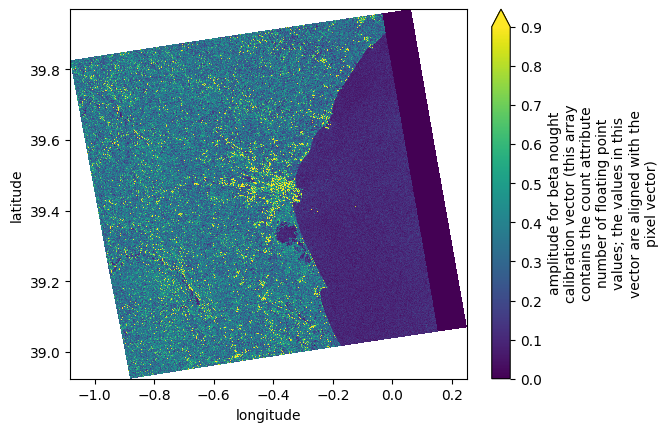

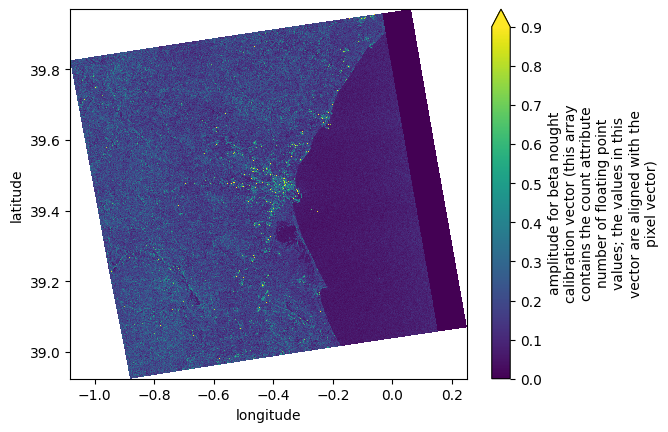

In [21]:
for i in [amplitudeVV[1], amplitudeVH[1]]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude", vmax=0.9)
    plt.show()

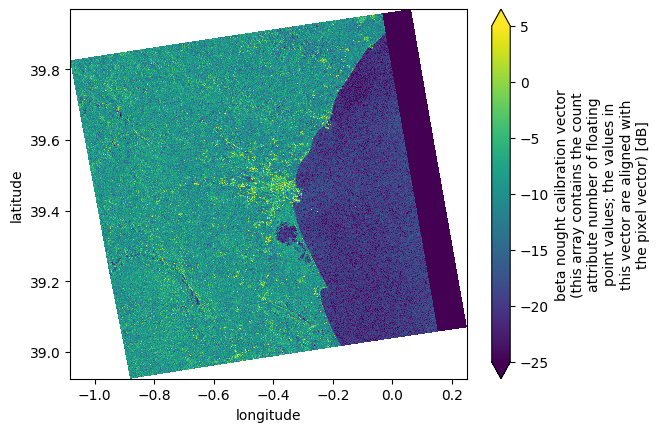

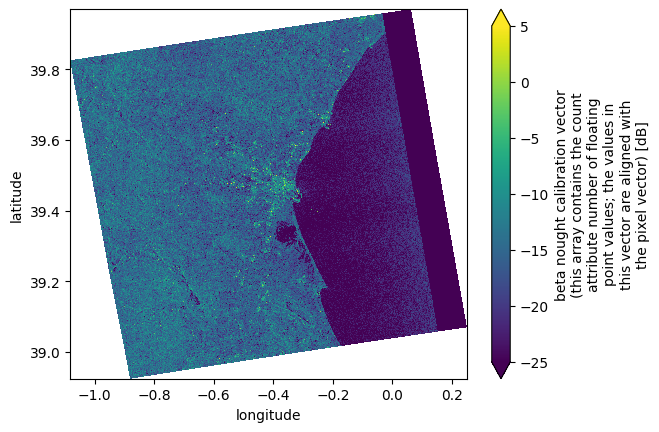

In [22]:
for i in [intensityVV[1], intensityVH[1]]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude", vmin=-25, vmax=5)
    plt.show()

In [23]:
# ndwi = (amplitudeVV[2] - amplitudeVH[2])/(amplitudeVV[2] + amplitudeVH[2]) # ~ ndwi amplitude
ndwi = (intensityVV[2] - intensityVH[2])/(intensityVV[2] + intensityVH[2]) # ~ ndwi intensity
# ndwi = intensityVV[2]/intensityVH[2] # intensity ratio

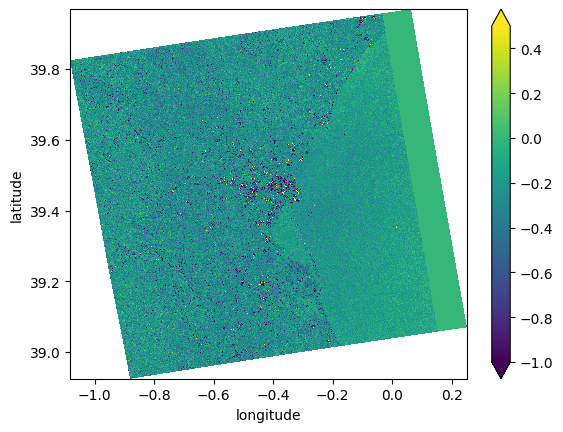

In [24]:
# ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=2) # amplitude
ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=0.5) # intensity
# ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=1) # intensity ratio
plt.show()

In [25]:
# water_mask_after = (intensity[2] <= WATER_THRESHOLD_DB) & (intensity[2] >= OTHER_THRESHOLD_DB)
# water_mask_before = (intensity[1] <= WATER_THRESHOLD_DB) & (intensity[1] >= OTHER_THRESHOLD_DB)

water_mask_before = (intensityVV[1] <= WATER_THRESHOLD_DB) 
water_mask_after = (intensityVV[2] <= WATER_THRESHOLD_DB) 
outro = (intensityVV[4] <= WATER_THRESHOLD_DB) 

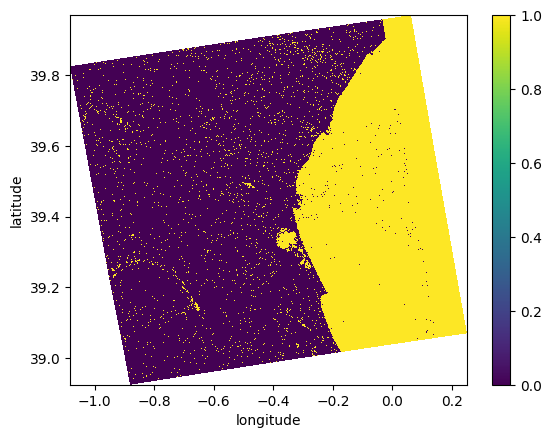

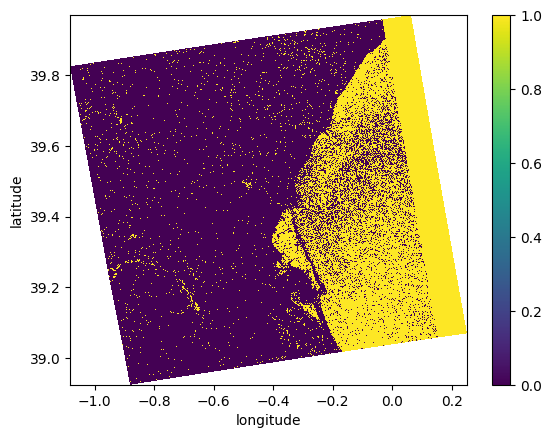

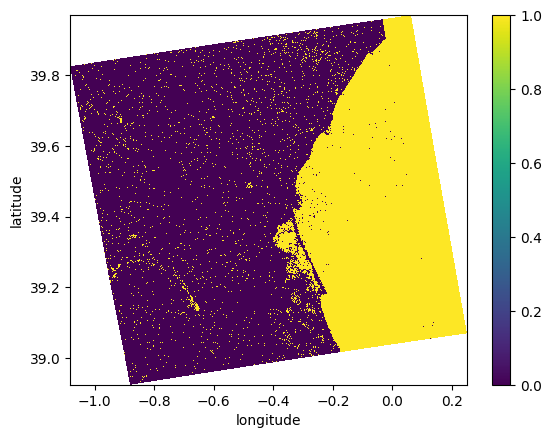

In [26]:
for i in [water_mask_before, water_mask_after, outro]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude")
    plt.show()

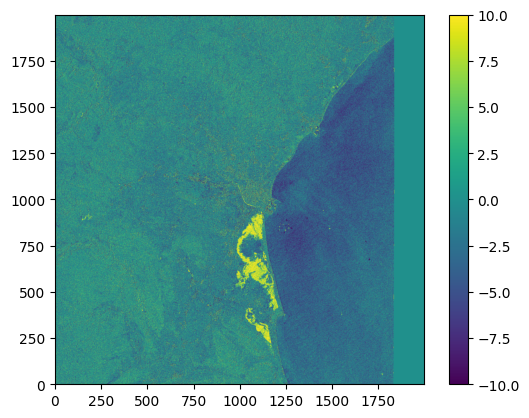

In [27]:
arr = (intensityVV[1].values-intensityVV[2].values)  
plt.imshow(arr, vmin=-10, vmax=10)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


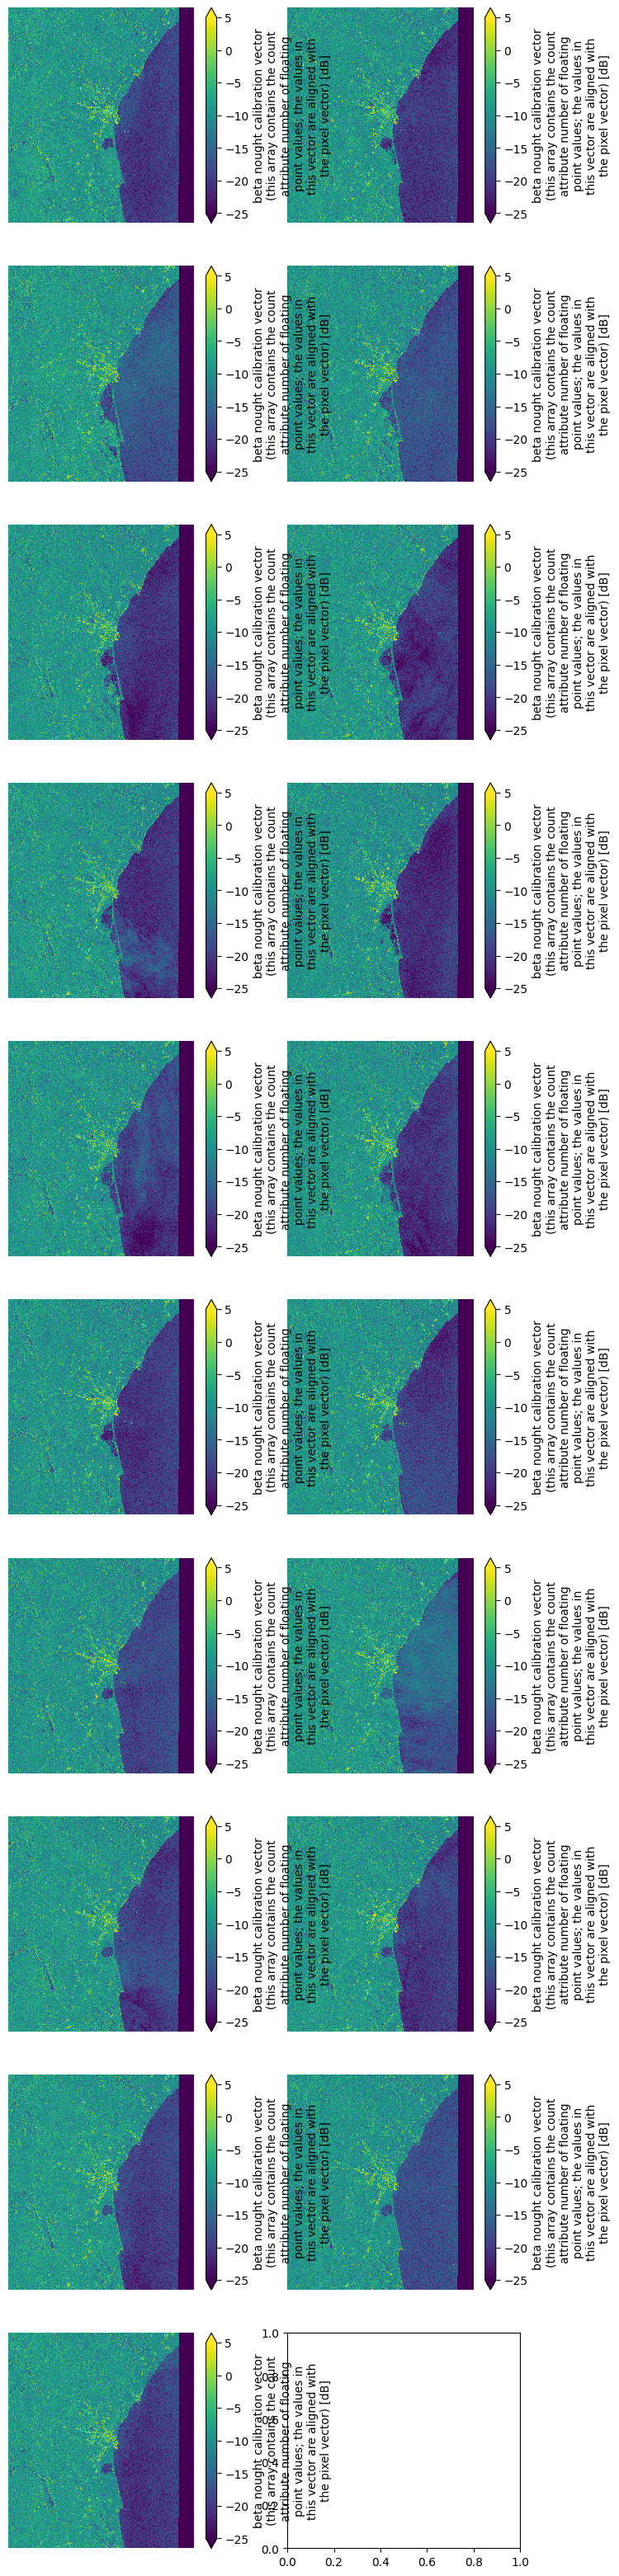

In [28]:
n_images = len(intensityVV)
n_cols = 2
n_rows = (n_images + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n_images:
        intensityVV[i].plot(ax=ax, vmin=-25, vmax=5)
        ax.axis('off')


plt.show()


In [29]:
target_lat = 39.29
target_lon = -0.32

abs_error = np.abs(intensityVV[1].latitude - target_lat) + np.abs(intensityVV[1].longitude - target_lon)

i, j = np.unravel_index(np.argmin(abs_error.values), abs_error.shape)

azimuth_time_value = intensityVV[1].azimuth_time[i].values
ground_range_value = intensityVV[1].ground_range[j].values
azimuth_time_index = i
ground_range_index = j

print("Nearest azimuth_time:", azimuth_time_value, ", with index:", azimuth_time_index)
print("Nearest ground_range:", ground_range_value, ", with index:", ground_range_index)


Nearest azimuth_time: 2024-10-19T18:03:10.909818977 , with index: 631
Nearest ground_range: 216020.0 , with index: 1108


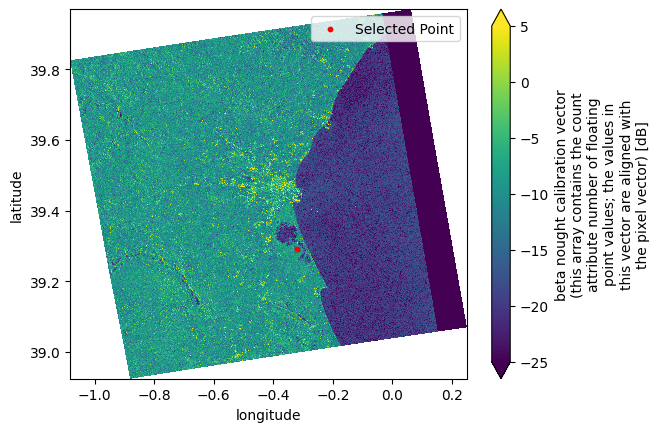

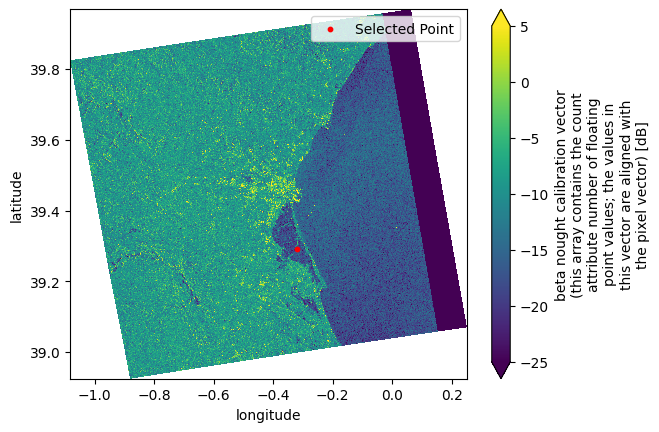

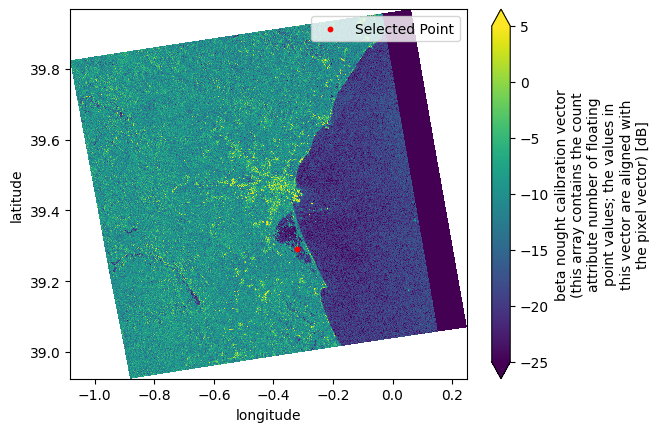

In [38]:
for i in [intensityVV[1], intensityVV[2], intensityVV[10]]:
    i.plot(
    x="longitude", 
    y="latitude", 
    vmin=-25, vmax=5
    )

    plt.scatter(
        target_lon, target_lat, 
        color="red", marker="o", s=10, 
        label="Selected Point"
    )

    plt.legend()
    plt.show()

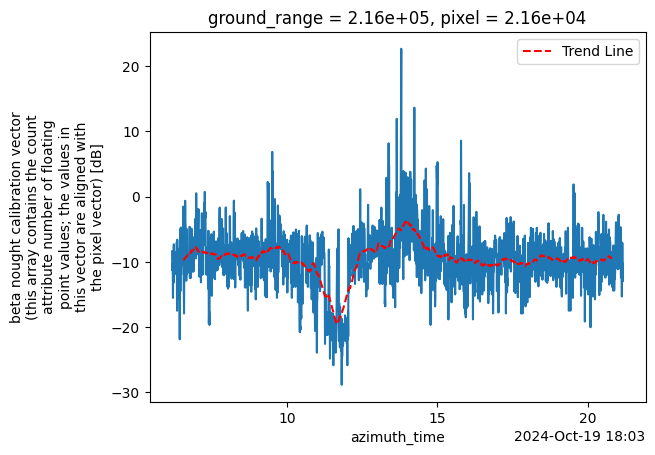

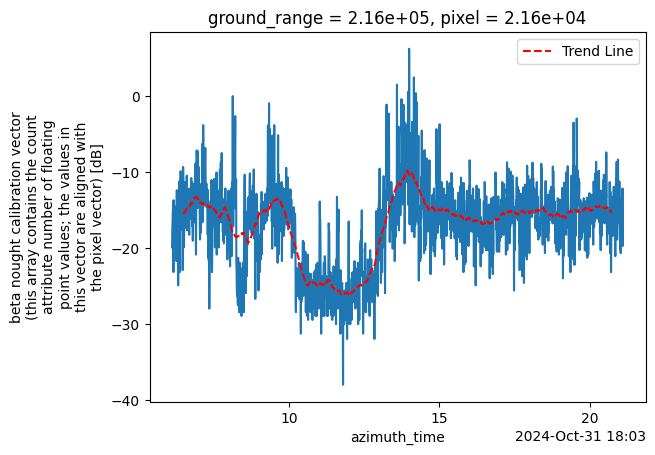

In [30]:
smoothness = 100
for i in [intensityVV[1].isel(ground_range=1108), intensityVH[2].isel(ground_range=1108)]:
    i.plot()
    x = i[i.dims[0]].values
    y = i.values

    trend = pd.Series(y).rolling(window=smoothness, center=True).mean()

    plt.plot(x, trend, color='red', linestyle='--', label='Trend Line')
    plt.legend()
    plt.show()

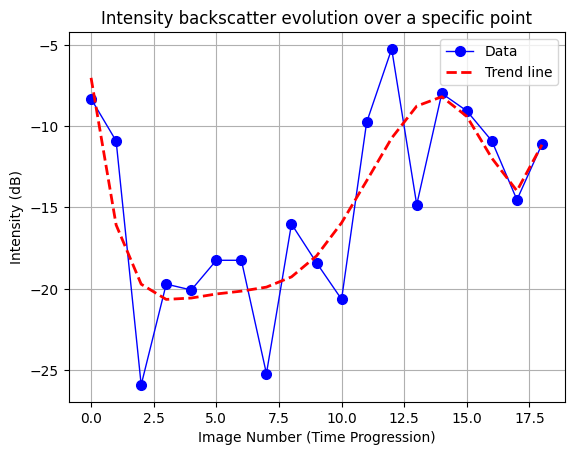

In [31]:
intensity_values = []
for img in intensityVV:
    location = img.isel(ground_range=1108, azimuth_time=631)
    intensity_values.append(location.values)

x = np.arange(len(intensity_values))
y = np.array(intensity_values)

z = np.polyfit(x, y, 7)  
p = np.poly1d(z)

plt.plot(x, y, 'b-o', label='Data', linewidth=1, markersize=7)
plt.plot(x, p(x), 'r--', label='Trend line', linewidth=2)
plt.xlabel("Image Number (Time Progression)")
plt.ylabel("Intensity (dB)")
plt.title("Intensity backscatter evolution over a specific point")
plt.grid()
plt.legend()
plt.show()
